In [84]:
from pathlib import Path

from docutils.nodes import reference

from CrystalTracer3D.io import CrystalReader
import napari

in_img = Path(r'D:\Zuohan\Z9\raw\Nude32_Z9_2025_05_30__00_49_24(15).czi')
a = CrystalReader(in_img)
segchan = a.find_channel('ChS2-T1')
img = a.read(channel=segchan)

viewer = napari.Viewer()
viewer.add_image(img, name='raw')

<Image layer 'raw' at 0x217b6523d30>

In [85]:
import pyclesperanto_prototype as cle
from skimage.filters import difference_of_gaussians, threshold_local
from skimage.exposure import adjust_gamma
from skimage.util import img_as_float32
# img2 = difference_of_gaussians(img, 1).clip(0)

img2 = difference_of_gaussians(img, 1).clip(0)
img2 = adjust_gamma(img2, 0.3)

segmented = cle.voronoi_otsu_labeling(img2, spot_sigma=1, outline_sigma=1)

viewer = napari.Viewer()
viewer.add_image(img2, name='raw')
viewer.add_labels(segmented, name='segmented')

<Labels layer 'segmented' at 0x217df335780>

SNR test

In [63]:
import numpy as np
from skimage.filters import gaussian

def snr(img, sigma=1):
    # Apply Gaussian blur to estimate the signal
    smoothed = gaussian(img, sigma, preserve_range=True)

    # Estimate noise
    noise = img - smoothed

    # Compute signal and noise power
    signal_power = np.mean(smoothed ** 2)
    noise_power = np.mean(noise ** 2)

    # Calculate SNR
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

snr(img)

7.530176940929142

In [65]:
snr(img)

9.890254908517985

In [67]:
snr(img)

10.619549440725365

In [69]:
snr(img)

7.643237072498465

In [74]:
snr(img)

7.71488539825414

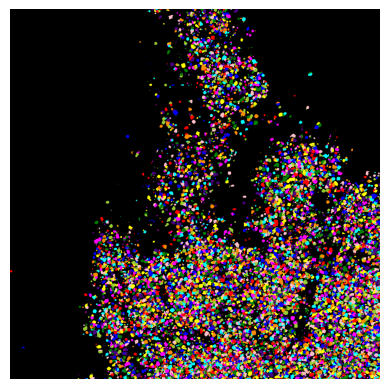

In [86]:

from skimage.color import label2rgb

def plot_label_snapshot(labels):
    proj = np.array(labels).max(axis=0)
    proj = label2rgb(proj)
    plt.imshow(proj)
    plt.axis('off')

plot_label_snapshot(segmented)

In [81]:
np.array(segmented)

array([[[     6,      6,      0, ...,      0,      0, 292686],
        [     6,      6,      6, ...,      0,      0,      0],
        [     6,      6,      6, ..., 291710,      0,      0],
        ...,
        [     0,   1383,   1383, ...,      0, 292685, 292685],
        [     0,      0,      0, ..., 292685, 292685,      0],
        [     0,      0,      0, ..., 292559, 292559,      0]],

       [[     6,      6,      6, ...,      0,      0, 292686],
        [     6,      6,      6, ...,      0,      0,      0],
        [     6,      6,      6, ..., 291710,      0,      0],
        ...,
        [     0,   1383,   1383, ...,      0,      0,      0],
        [  1383,   1383,   1383, ...,      0,      0,      0],
        [  1383,      0,      0, ..., 292559,      0,      0]],

       [[     1,      1,      6, ...,      0,      0,      0],
        [     0,      6,      6, ..., 292687,      0,      0],
        [     0,      6,      6, ..., 291710,      0,      0],
        ...,
        [   

visualize 2d

In [86]:
import matplotlib.pyplot as plt
from skimage.util import img_as_float32
import nrrd

data, header = nrrd.read(r"D:\Zuohan\Z9\heatmap.nrrd")
data = img_as_float32(data.max(axis=0))

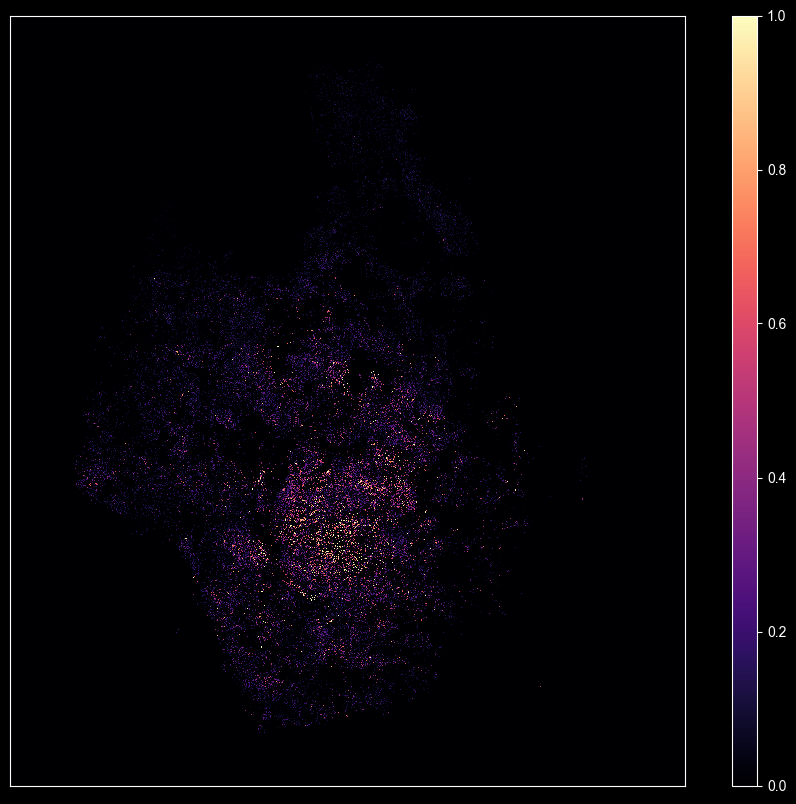

In [87]:
fig, ax = plt.subplots(facecolor='black', figsize=(12, 10))
plt.style.use('dark_background')
plt.imshow(data, cmap='magma', interpolation='nearest')
ax.set_xticks([])
ax.set_yticks([])
cbar = plt.colorbar(aspect=30)
plt.savefig(r'D:\Zuohan\Z9\ratiometric.png', dpi=300)

visualize 3d

In [1]:
import napari
import nrrd
from napari.utils import Colormap
from matplotlib import cm
import numpy as np

n = 1024
mpl_cmap = cm.get_cmap('seismic', n)
rgba = mpl_cmap(np.linspace(0, 1, n))
vispy_cmap = Colormap(rgba, bad_color=[0,0,0,0])
# rgba = np.vstack([[0,0,0,0], rgba])
# vispy_cmap = Colormap(rgba)
heatmap, _ = nrrd.read(r"D:\Zuohan\Z9-mag\ratiometrics.nrrd")
heatmap = np.log(heatmap)

vessel, _ = nrrd.read(r"X:\All Data\Lab Members\Zuohan Zhao\02_Processed Data\segmentation\ratiometrics-mag\vessel.nrrd")
vessel = vessel > 0

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(
    heatmap[::-1],
    name='3D_heatmap',
    colormap=vispy_cmap,
    blending='additive',
    rendering='attenuated_mip',
    opacity=0.7,
    scale=[8, 1, 1],
)
viewer.add_labels(
    vessel[::-1],
    opacity=0.7,
    name='vessel_local',
    colormap={1: '#B0FC38'},
    scale=[8, 1, 1],
)

C:\Users\LinLab_Workstation4\AppData\Local\Temp\ipykernel_11700\2010591137.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mpl_cmap = cm.get_cmap('seismic', n)
C:\Users\LinLab_Workstation4\AppData\Local\Temp\ipykernel_11700\2010591137.py:14: RuntimeWarning: invalid value encountered in log
  heatmap = np.log(heatmap)
C:\Users\LinLab_Workstation4\Documents\GitHub\AutoPhotoPicking\.venv\lib\site-packages\napari\utils\colormaps\colormap.py:447: UserWarning: color_dict did not provide a default color. Missing keys will be transparent. To provide a default color, use the key `None`, or provide a defaultdict instance.
  warn(


<Labels layer 'vessel' at 0x1e9650ed840>

adjust visual

In [2]:
viewer.layers[0].bounding_box.visible = True
viewer.layers[0].bounding_box.line_color = [1, 1, 1, 1]
viewer.layers[0].bounding_box.points = False
viewer.camera.perspective = 30

export

In [7]:
viewer.layers[0].bounding_box.line_thickness = 1
# line width has to increase if scale is increased
viewer.screenshot(path=r'D:\Zuohan\Z9-mag\ratiometrics_3D.png', scale=1, canvas_only=True)

array([[[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       ...,

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0

vessel

In [94]:
from skimage.io import imread

a = imread(r"D:\Zuohan\Z9\ves_raw_mip.png")

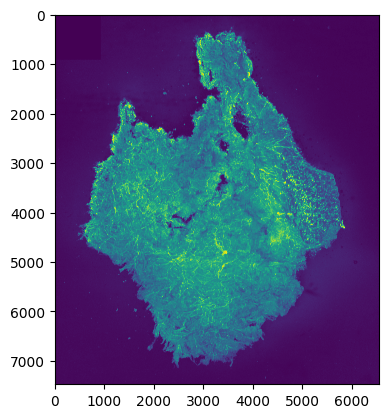

In [102]:
import matplotlib.pyplot as plt
img = a
img = (img - img.mean()) / img.std()
img = img.clip(-3, 3)
plt.imshow(img)

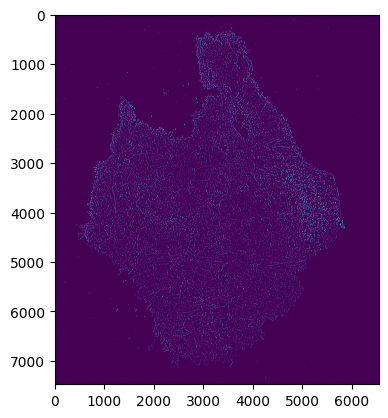

In [137]:
img2 = difference_of_gaussians(img, 5).clip(0)
plt.imshow(img2)

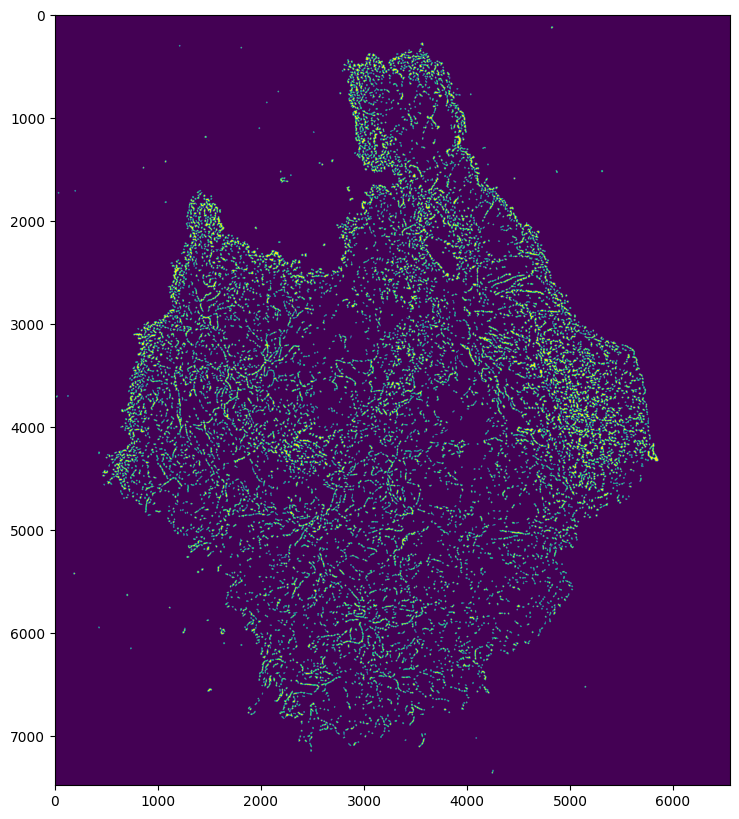

In [140]:
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects
thr = threshold_otsu(img2)
seg = img2 > thr
seg = remove_small_objects(seg, 100, 3)
plt.figure(figsize=(10, 10))
plt.imshow(seg)

vessel 3D

In [82]:
from CrystalTracer3D.io import CrystalReader

path = r'D:\Zuohan\Z9\raw\Nude32_Z9_2025_05_30__00_49_24(23).czi'
reader = CrystalReader(path)
ves_chan = reader.find_channel('Ch2-T2')
a = reader.read(ves_chan)

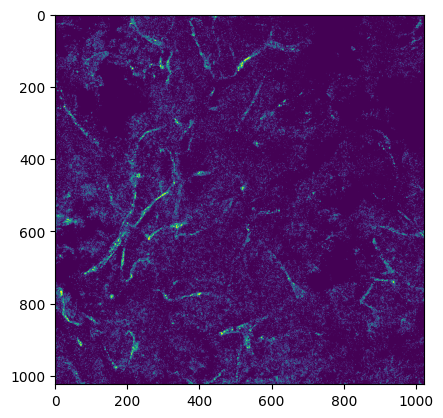

In [84]:
img = a
img = (img - img.mean()) / img.std()
img = img.clip(2, 5)
plt.imshow(img[12])

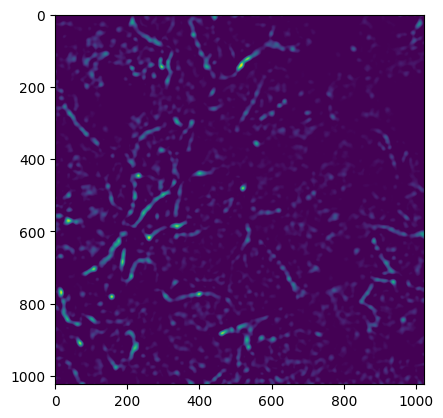

In [85]:
from skimage.filters import difference_of_gaussians

img2 = difference_of_gaussians(img, (1, 5, 5)).clip(0)
plt.imshow(img2[12])

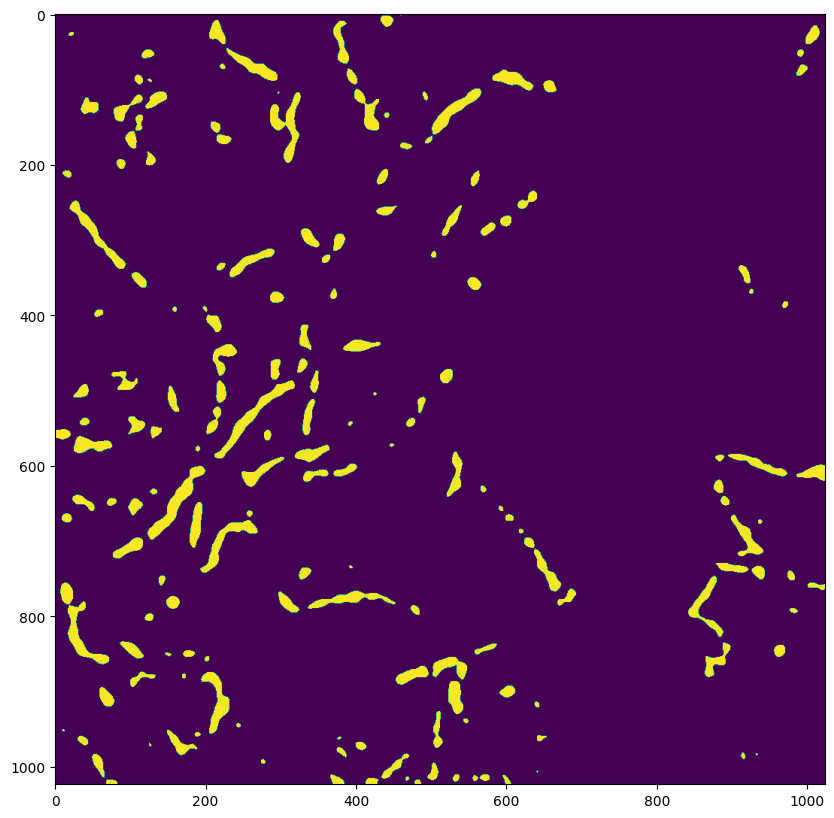

In [86]:
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects
thr = threshold_otsu(img2)
seg = img2 > thr
seg = remove_small_objects(seg, 1000, 3)
plt.figure(figsize=(10, 10))
plt.imshow(seg[12])

In [88]:
viewer = napari.Viewer()
viewer.add_image(
    seg,
)
napari.run()

In [6]:
import napari
import numpy as np

# data, header = nrrd.read(r"D:\Zuohan\Z9\ves_seg.nrrd")
data = np.load(r"D:\Zuohan\Z9\ves\Nude32_Z9_2025_05_30__00_49_24(25)\vessel.npy")
viewer = napari.Viewer()
viewer.add_image(
    data,
)
napari.run()

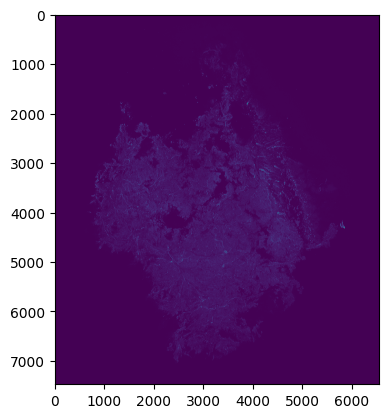

In [1]:
import nrrd
import matplotlib.pyplot as plt

whole, head = nrrd.read(r"D:\Zuohan\Z9\ves_raw.nrrd")
plt.imshow(whole[12])


check some tiles

In [75]:
from CrystalTracer3D.io import CrystalReader
a = CrystalReader(r'D:\Zuohan\Z9\raw\Nude32_Z9_2025_05_30__00_49_24(24).czi')
img = a.read(0)

In [76]:
from skimage.filters import difference_of_gaussians

img = difference_of_gaussians(img, 1).clip(0)

import napari

viewer = napari.Viewer()
viewer.add_image(img)

<Image layer 'img' at 0x22b9fbf94e0>

check segmentation

In [128]:
import napari
import nrrd
from CrystalTracer3D.io import CrystalReader

crystal, _ = nrrd.read(r"D:\Zuohan\Z9-mag\crystal.nrrd")
img = CrystalReader(r"Y:\All Data\Lab Members\Jiaxi Lu\02_Processed Data\20250505_ReviewData\3_invivo_NFkB_recording\3_3_SpatialRecording\WholeSlice_Nude32IHC\z9highmag_Nude34_Z9_2025_05_15__02_30_42-Create Image Subset-48.czi")
img = img.assemble_tiles(img.find_channel('ChS1-T2'))

In [130]:
viewer = napari.Viewer()
viewer.add_image(img, scale=[4, 1, 1])
viewer.add_labels(
    crystal,
    scale=[4, 1, 1],
)
napari.run()

In [89]:
from skimage.morphology import reconstruction
from skimage.filters import gaussian
from skimage.exposure import adjust_gamma
import numpy as np
i = gaussian(adjust_gamma(img[22], 0.5), 3)
seed = np.copy(i)
seed[1:-1, 1:-1] = i.max()
mask = i
filled = reconstruction(seed, mask, method='erosion')

# viewer = napari.Viewer()
# viewer.add_image(filled)
# napari.run()

In [90]:
from skimage.filters import difference_of_gaussians
dog = difference_of_gaussians(filled, 0, 10).clip(0)
# viewer = napari.Viewer()
# viewer.add_image(dog)
# napari.run()

In [91]:
from gwdt import gwdt
from scipy.ndimage import generate_binary_structure

structure = generate_binary_structure(2, 10)
dist = gwdt(dog, structure)

viewer = napari.Viewer()
viewer.add_image(dist)
napari.run()

In [92]:
import pyclesperanto_prototype as cle
from skimage.segmentation import expand_labels

labels = cle.voronoi_otsu_labeling(dist, spot_sigma=1, outline_sigma=0)
labels = expand_labels(np.array(labels), 3)
viewer = napari.Viewer()
viewer.add_image(img[22])
viewer.add_labels(labels)
napari.run()

process in 2D and segment in 3D

In [103]:
from tqdm import tqdm
from scipy.ndimage import label
labels = []
for i in tqdm(img):
     # smooth and enhance weak ones
    i = gaussian(adjust_gamma(i, 0.5), 3)
    # fill holes
    seed = np.copy(i)
    seed[1:-1, 1:-1] = i.max()
    mask = i
    i = reconstruction(seed, mask, method='erosion')
    # bg removal
    dog = difference_of_gaussians(i, 0, 10).clip(0)
    structure = generate_binary_structure(2, 10)
    dt = gwdt(dog, structure)
    seg = cle.voronoi_otsu_labeling(dt, spot_sigma=1, outline_sigma=0)
    labels.append(seg)
labels = np.stack(labels)
labels, _ = label(labels > 0)
labels = expand_labels(labels, 3)

In [105]:
viewer = napari.Viewer()
viewer.add_image(img, scale=[8, 1, 1])
viewer.add_labels(labels, scale=[8, 1, 1])
napari.run()

In [118]:
from tqdm import tqdm
processed = []
for i in tqdm(match):
     # smooth and enhance weak ones
    i = gaussian(adjust_gamma(i, 0.5), 3)
    # fill holes
    seed = np.copy(i)
    seed[1:-1, 1:-1] = i.max()
    mask = i
    i = reconstruction(seed, mask, method='erosion')
    # bg removal
    dog = difference_of_gaussians(i, 0, 10).clip(0)
    structure = generate_binary_structure(2, 10)
    dt = gwdt(dog, structure)
    processed.append(dt)
processed = np.stack(processed)
labels = cle.voronoi_otsu_labeling(processed, spot_sigma=1, outline_sigma=0)
labels = expand_labels(np.array(labels), 3)

100%|██████████| 26/26 [00:29<00:00,  1.13s/it]


In [120]:
viewer = napari.Viewer()
viewer.add_image(img, scale=[8, 1, 1])
viewer.add_labels(labels, scale=[8, 1, 1])
napari.run()

histogram matching test

In [116]:

from skimage.exposure import match_histograms
match = []
ref = img[12]
for i in img:
    match.append(match_histograms(i, ref))
match = np.stack(match)

In [117]:
viewer = napari.Viewer()
viewer.add_image(match, scale=[8, 1, 1])
napari.run()